In [1]:
from pathlib import Path
import os

from matchms.importing import load_from_mgf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from ms2deepscore import SpectrumBinner
from ms2deepscore.data_generators import DataGeneratorAllInchikeys
from ms2deepscore.models import SiameseModel
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model


from sklearn.model_selection import train_test_split


In [2]:
discarded_exps = ['xuan_151118_E1',
'xuan_15319_E1' ,
'xuan_20919_E2',
'xuan_27919_E1',
'xuan_27919_E2',
'xuan_27919_E3',
'NC_20717_E5' ,
'NC_25717_E2',
'payam_31019_E5',
'payam_101019_E5',
'NC_24717_E1']

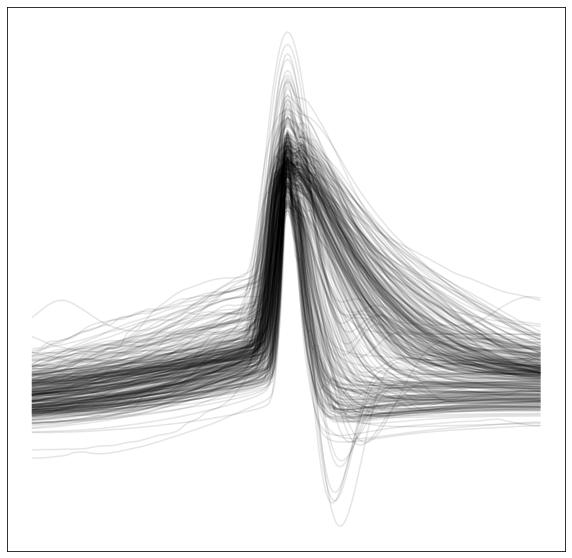

In [3]:
# %matplotlib widget

ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated.pkl")
ephys = ephys[~ephys.exp_name.isin(discarded_exps)]


data_ephys_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][ephys.columns[1:]]
data_ephys_FN_acsf = data_ephys_FN_acsf[data_ephys_FN_acsf.trialnr==0]
data_ephys_FN_acsf = data_ephys_FN_acsf.drop_duplicates('exp_name')


data_wave_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][['waveform','tau', 'exp_name', 'cond', 'trialnr']]
data_wave_FN_acsf=data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]
data_wave_FN_acsf.drop_duplicates('exp_name')

# exps_with_double_trials = np.array(data_wave_FN_acsf.exp_name)[list(np.where(np.unique(data_wave_FN_acsf.exp_name,return_counts=True)[1]>1)[0])]
# data_wave_FN_acsf = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]

fig,ax = plt.subplots(figsize=[10,10])
# plt.ion
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.1)
plt.xticks([])
plt.yticks([])
plt.show()


In [4]:
def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1]
    date = date.replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string or 'payam' in string :
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

In [5]:
df_bio = pd.read_csv('D:/Biophysical_cluster/cluster_params_rect_filt.csv')
df_bio.exp_name = df_bio.exp_name.apply(return_name_date_exp_fn)
df_bio = df_bio[~df_bio.exp_name.isin(discarded_exps)]
df_bio = df_bio[df_bio.columns[1:]]
df_bio_acsf = df_bio[df_bio.cond.isin(['ACSF','aCSF','aCSF_BIC'])]
df_bio_acsf = df_bio_acsf[df_bio_acsf.trial==0]
df_bio_acsf = df_bio_acsf[df_bio_acsf.rsqared_V>0.7]
df_bio_acsf = df_bio_acsf.drop_duplicates('exp_name')


In [6]:
df_sta = pd.read_pickle('D:/CurrentClamp/all_stas_hidden_spikes_computed.pkl')
df_sta.trial = df_sta.trial.apply(int)
df_sta = df_sta[~df_sta.exp_name.isin(discarded_exps)]
df_sta_acsf = df_sta[df_sta.cond.isin(['acsf','acsf_bic'])]

df_sta_acsf = df_sta_acsf[df_sta_acsf.exp_name.isin(set(data_wave_FN_acsf.exp_name))]
df_sta_acsf = df_sta_acsf[df_sta_acsf.trial==0]
df_sta_acsf = df_sta_acsf.drop_duplicates('exp_name')



In [7]:
common_exps = (set(df_sta_acsf.exp_name) & set(df_bio_acsf.exp_name)) & set(data_ephys_FN_acsf.exp_name) 

df_ephys = data_ephys_FN_acsf[data_ephys_FN_acsf.exp_name.isin(common_exps)]
df_sta   = df_sta_acsf[df_sta_acsf.exp_name.isin(common_exps)]
df_bio   = df_bio_acsf[df_bio_acsf.exp_name.isin(common_exps)]

cols_bio = ['tau_m (ms)', 'R (MOhm):', 'C (nF):', 'gl (nS):', 'El (mV):', 'Vr (mV):', 'Vt* (mV):', 'DV (mV):' ]

X_ephys = np.vstack(df_ephys[df_ephys.columns[:-4]].to_numpy())
X_sta = np.vstack(df_sta['sta'].to_numpy())
X_bio = np.vstack(df_bio[cols_bio].to_numpy())

In [8]:
def return_shuffled_inds(ind1,ind2):
    SHUFFLED = True

    while SHUFFLED:
        indices_rand1 = ind1
        indices_rand2 = ind2
        

        np.random.shuffle(indices_rand1)
        np.random.shuffle(indices_rand2)

        if len(np.where(indices_rand1-indices_rand2==0)[0])==0:
            SHUFFLED=False
    return indices_rand1,indices_rand2


In [9]:
idx1,idx2= return_shuffled_inds(np.arange(len(X_bio)),np.arange(len(X_bio)))

BIO_X,  STA_X    = np.vstack([X_bio,X_bio[idx1]])     ,np.vstack([X_sta,X_sta[idx2]])
# STA_X , EPHYS_X  = np.vstack([X_sta,X_sta[idx1]])     ,np.vstack([X_ephys,X_ephys[idx2]])
# EPHYS_X,BIO_X    = np.vstack([X_ephys,X_ephys[idx1]]) ,np.vstack([X_bio,X_bio[idx2]]) 

y = np.hstack([np.ones(len(X_bio)),np.zeros(len(X_bio))])


In [10]:


import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


# X1_ephys_train,X1_ephys_test,X2_sta_train,X2_sta_test, y_train, y_test = train_test_split(EPHYS_X,STA_X, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)
X1_bio_train,X1_bio_test,X2_sta_train,X2_sta_test, y_train, y_test     = train_test_split(BIO_X ,STA_X, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)
# X1_ephys_train,X1_ephys_test,X2_bio_train,X2_bio_test, y_train, y_test = train_test_split(EPHYS_X,BIO_X, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)





In [56]:
#corr part of the same trial
model = SiameseModel(8,2000, base_dims=(10, 100), embedding_dim=5, dropout_rate=0.1, seperate_base=True) #corr

model.compile(loss='mse', optimizer= Adam(learning_rate=0.01), metrics=["mae", "mse",])

# Save best model and include earlystopping
earlystopper_scoring_net = EarlyStopping(monitor='val_mse', mode="min", patience=10, verbose=1, restore_best_weights=True)
model.summary()


from sklearn.metrics.pairwise import cosine_similarity
x1_test,x2_test =    model.return_embeddings(X1_bio_test, X2_sta_test)

MAE_dummy = np.abs(y_test  - np.hstack(keras.layers.Dot(axes=(1, 1), normalize=True,name="cosine_similarity")([x1_test, x2_test]).numpy()))
MAE_dummy = np.mean(MAE_dummy)
MSE_dummy = np.mean(MAE_dummy**2)

Model: "base_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 8)]               0         
                                                                 
 dense1 (Dense)              (None, 10)                90        
                                                                 
 normalization1 (BatchNorma  (None, 10)                40        
 lization)                                                       
                                                                 
 dense2 (Dense)              (None, 100)               1100      
                                                                 
 normalization2 (BatchNorma  (None, 100)               400       
 lization)                                                       
                                                                 
 dropout2 (Dropout)          (None, 100)               0    

In [57]:
checkpoint_path = "D:\siamese_trained_models\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)
#Correlated features
history_corr = model.model.fit(x={'input_a':X1_bio_train,'input_b':X2_sta_train},y=y_train.astype('float32'), 
                          validation_data=({'input_a':X1_bio_test,'input_b':X2_sta_test},y_test),
                          epochs=200, 
                          verbose=1, 
                          callbacks=[])
                                         

Epoch 1/200
13/13 [==============================] - 4s 34ms/step - loss: 0.3140 - mae: 0.4596 - mse: 0.3132 - val_loss: 0.4923 - val_mae: 0.5448 - val_mse: 0.4913
Epoch 2/200
13/13 [==============================] - 0s 10ms/step - loss: 0.2470 - mae: 0.4206 - mse: 0.2459 - val_loss: 0.4434 - val_mae: 0.5324 - val_mse: 0.4422
Epoch 3/200
13/13 [==============================] - 0s 8ms/step - loss: 0.2358 - mae: 0.4151 - mse: 0.2346 - val_loss: 0.4867 - val_mae: 0.5443 - val_mse: 0.4854
Epoch 4/200
13/13 [==============================] - 0s 8ms/step - loss: 0.2387 - mae: 0.4160 - mse: 0.2374 - val_loss: 0.4889 - val_mae: 0.5451 - val_mse: 0.4876
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 0.2243 - mae: 0.3739 - mse: 0.2231 - val_loss: 0.3456 - val_mae: 0.4443 - val_mse: 0.3443
Epoch 6/200
13/13 [==============================] - 0s 8ms/step - loss: 0.2165 - mae: 0.3844 - mse: 0.2152 - val_loss: 0.3964 - val_mae: 0.5097 - val_mse: 0.3951
Epoch 7/200
13/13 [=

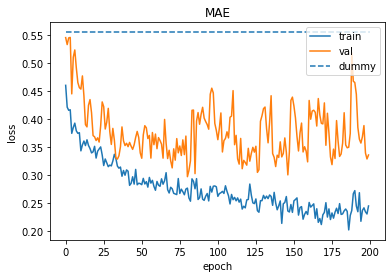

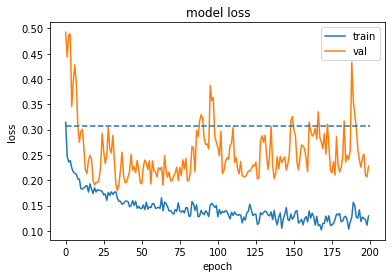

In [58]:
from matplotlib import pyplot as plt


plt.plot(history_corr.history['mae'])
plt.plot(history_corr.history['val_mae'])
plt.title('MAE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.hlines(MAE_dummy,0,200,linestyles='dashed')
plt.legend(['train', 'val','dummy'], loc='upper right')
plt.show()

plt.plot(history_corr.history['loss'])
plt.plot(history_corr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val','dummy'], loc='upper right')
plt.hlines(MSE_dummy,0,200,linestyles='dashed')
plt.show()

In [59]:



emb1,emb2 = model.return_embeddings(BIO_X, STA_X)


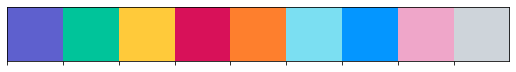

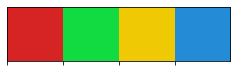

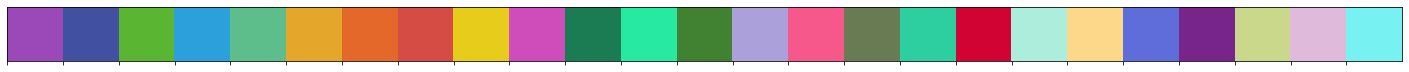

In [60]:
import seaborn as sns 
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
 [0.259, 0.314, 0.635],
 [0.351, 0.712, 0.198],
 [0.176, 0.631, 0.859],
 [0.369, 0.749, 0.549],
 [0.898, 0.654, 0.169],
 [0.898, 0.41, 0.165],
 [0.834, 0.3, 0.265],
 [0.912, 0.8, 0.112],
 [0.812, 0.3, 0.734],
 [0.109, 0.483, 0.324],
 [0.159, 0.914, 0.635],
 [0.251, 0.512, 0.198],
 [0.676, 0.631, 0.859],
 [0.969, 0.349, 0.549],
 [0.409, 0.483, 0.324],
 [0.179, 0.814, 0.635],
 [0.821, 0.012, 0.198],
 [0.676, 0.931, 0.859],
 [0.989, 0.849, 0.549],
 [0.376, 0.431, 0.859],
 [0.469, 0.149, 0.549],
 [0.789, 0.849, 0.549],
 [0.876, 0.731, 0.859],
 [0.469, 0.949, 0.949],
  
 
 ]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pickle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import *
import umap
import os
from sknetwork.clustering import Louvain,get_modularity
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


18


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


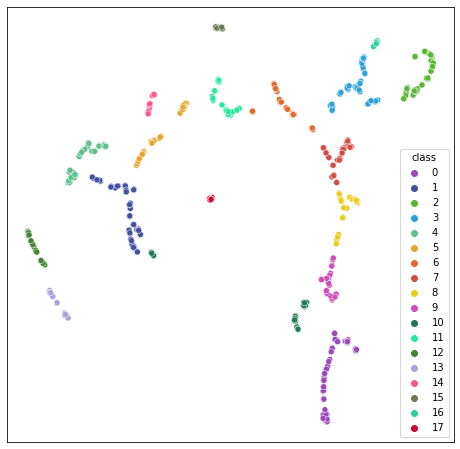

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


23


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


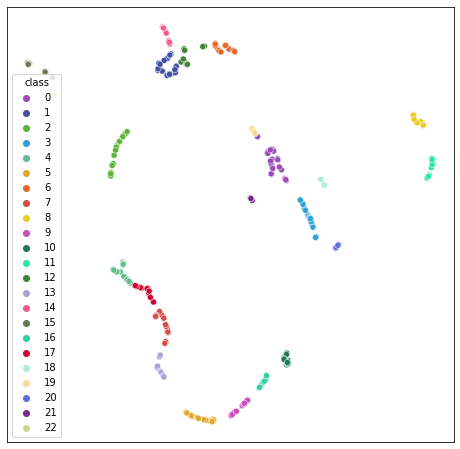

In [61]:
labels_bio,_,_=plot_UMAP_clusters_single(emb1,20,0.1,1.,42,c_list= coherence_colors)
labels_sta,_,_=plot_UMAP_clusters_single(emb2,20,0.1,1.,42,c_list= coherence_colors)


In [62]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score



print((adjusted_rand_score(labels_bio,labels_sta) , 
adjusted_mutual_info_score(labels_bio,labels_sta)))


(0.01772023073458719, 0.040346175544991716)
